In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_auc_score
import pickle
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('drive/My Drive/Capstone Dataset')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import csv
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import io
import json
import random

def parse_data_from_file(filename):
    """
    Extracts sentences and labels from a CSV file
    
    Args:
        filename (string): path to the CSV file
    
    Returns:
        sentences, labels (list of string, list of string): tuple containing lists of sentences and labels
    """
    sentences = []
    sentiment = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            sentiment.append(int(row[3]))
            sentence = row[1]
            sentences.append(sentence)

    return sentences, sentiment

def train_val_test_split(sentences, sentiment, training_split):    
    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = int(len(sentences) * training_split)
    # val_size = train_size + int(len(sentences) * val_split)

    # Split the sentences and labels into train/validation splits
    train_sentences = sentences[:train_size]
    train_sentiment = sentiment[:train_size]

    validation_sentences = sentences[train_size:]
    validation_sentiment = sentiment[train_size:]

    # test_sentences = sentences[val_size:]
    # test_sentiment = sentiment[val_size:]
    
    return train_sentences, validation_sentences, train_sentiment, validation_sentiment

def fit_tokenizer(train_sentences, num_words, oov_token):
  tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
  tokenizer.fit_on_texts(train_sentences)

  return tokenizer

def seq_and_pad(sentences, tokenizer, padding, maxlen):
    """
    Generates an array of token sequences and pads them to the same length
    
    Args:
        sentences (list of string): list of sentences to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        maxlen (int): maximum length of the token sequence
    
    Returns:
        padded_sequences (array of int): tokenized sentences padded to the same length
    """    
       
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences using the correct padding and maxlen
    padded_sequences = pad_sequences(sequences, padding=padding, maxlen=maxlen)

    return padded_sequences

def load_data():
    """
    Loads the data from the CSV files and splits them into train/validation/test sets
    
    Returns:
        train_sentences, validation_sentences, train_sentiment, validation_sentiment
    """
    # Load the data
    sentences, sentiment = parse_data_from_file('processed_review_binary.csv')

    # Bundle the two lists into a single one
    sentences_and_sentiment = list(zip(sentences, sentiment))

    # Perform random sampling
    random.seed(42)
    sentences_and_sentiment = random.sample(sentences_and_sentiment, len(sentences))

    # Unpack back into separate lists
    sentences, sentiment = zip(*sentences_and_sentiment)

    # Split the data into train/validation/test sets
    train_sentences, validation_sentences, train_sentiment, validation_sentiment = train_val_test_split(sentences, sentiment, 0.8)

    # fit tokenizer
    tokenizer = fit_tokenizer(train_sentences, num_words=NUM_WORDS, oov_token=OOV_TOKEN)
    word_index = tokenizer.word_index
     # save tokenizer vocabulary to file
    tokenizer_json = tokenizer.to_json()
    with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
        f.write(json.dumps(tokenizer_json, ensure_ascii=False))

    # sequencing and padding sentences
    train_padded_sentences = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
    validation_padded_sentences = seq_and_pad(validation_sentences, tokenizer, PADDING, MAXLEN)
    # test_padded_sentences = seq_and_pad(test_sentences, tokenizer, PADDING, MAXLEN)

    # initializing vocab_size
    vocab_size = len(word_index) + 1

    # converting sentences into numpy arrays
    train_sentences = np.array(train_padded_sentences)
    validation_sentences = np.array(validation_padded_sentences)
    # test_sentences = np.array(test_padded_sentences)

    # converting sentiment into numpy arrays
    train_sentiment = np.array(train_sentiment)
    validation_sentiment = np.array(validation_sentiment)
    # test_sentiment = np.array(test_sentiment)

    print("Finished loading data\n")

    return train_sentences, validation_sentences, train_sentiment, validation_sentiment, vocab_size, word_index

In [ ]:
NUM_WORDS = 90000
EMBEDDING_DIM = 100
MAXLEN = 225
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRUNC_TYPE = 'post'
PADD_TYPE = 'post'

In [ ]:
def create_model(vocab_size, max_length, embedding_dim, word_index):
    
    lstm1_dim = 64
    lstm2_dim = 32
    dense_dim = 32

    embeddings_index = {}
    with io.open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            curr_word = values[0]
            coefs = np.asarray(values[1:], dtype='float64')
            embeddings_index[curr_word] = coefs

    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    # create the model
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm1_dim, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm2_dim)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(dense_dim, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['auc'])
    return model    

In [ ]:
def create_model2(vocab_size, max_length, embedding_dim, word_index):
    
    lstm1_dim = 64
    lstm2_dim = 32
    dense_dim = 64

    embeddings_index = {}
    with io.open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            curr_word = values[0]
            coefs = np.asarray(values[1:], dtype='float64')
            embeddings_index[curr_word] = coefs

    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    # create the model
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', kernel_constraint= tf.keras.constraints.MaxNorm( max_value=3, axis=[0,1])),
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=4),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['auc'])
    return model    

In [ ]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.layers import Input, Embedding, Conv1D, Dropout, MaxPool1D, Flatten, Dense, Bidirectional, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate

def create_model3(vocab_size, max_length, embedding_dim, word_index):
    
    lstm1_dim = 64
    lstm2_dim = 32
    dense_dim = 64

    embeddings_index = {}
    with io.open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            curr_word = values[0]
            coefs = np.asarray(values[1:], dtype='float64')
            embeddings_index[curr_word] = coefs

    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    
    # Input Layer 1
    input1 = Input(shape=(max_length,))
    embeddding1 = Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False)(input1)
    conv1 = Conv1D(filters=100, kernel_size=3, activation='relu', 
                   kernel_constraint= MaxNorm( max_value=3, axis=[0,1]))(embeddding1)
    pool1 = MaxPool1D(pool_size=2, strides=2)(conv1)
    flat1 = Flatten()(pool1)
    drop1 = Dropout(0.5)(flat1)
    dense1 = Dense(10, activation='relu')(drop1)
    drop1 = Dropout(0.5)(dense1)
    out1 = Dense(1, activation='sigmoid')(drop1)

    # Input Layer 2
    input2 = Input(shape=(max_length,))
    embeddding2 = Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False)(input2)
    gru2 = Bidirectional(GRU(64))(embeddding2)
    drop2 = Dropout(0.5)(gru2)
    out2 = Dense(1, activation='sigmoid')(drop2)

    # create the model
    merged = concatenate([out1, out2])
    
    # Interpretation
    outputs = Dense(1, activation='sigmoid')(merged)
    model = Model(inputs=[input1, input2], outputs=outputs)
    
    # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['auc'])
    return model  

In [ ]:
training_finished = False

x_train, x_val, y_train, y_val, vocab_size, word_index = load_data()

class scoreTarget(tf.keras.callbacks.Callback):
  def __init__(self, target):
    super(scoreTarget, self).__init__()
    self.target = target

  def on_epoch_end(self, epoch, logs={}):
    acc = logs['auc']
    if acc >= self.target:
      self.model.stop_training = True

class ROAUCMetrics(tf.keras.callbacks.Callback):
    def __init__(self, val_data):
        super().__init__()
        self.valid_x = val_data[0]
        self.valid_y = val_data[1]

    def on_train_begin(self, logs={}):
        self.val_aucs = []

    def on_epoch_end(self, epoch, logs={}):
        pred = self.model.predict(self.valid_x)
        val_auc = roc_auc_score(self.valid_y, pred,  average='micro')
        print('\nval-roc-auc: %s' % (str(round(val_auc,4))),end=100*' '+'\n')
        self.val_aucs.append(val_auc)
        return

roc = ROAUCMetrics(val_data=(x_val, y_val))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5) # metric stop improving
tensorboard    = tf.keras.callbacks.TensorBoard() 
reduce_lr      = tf.keras.callbacks.ReduceLROnPlateau(patience=3)
# target         = scoreTarget(0.96)


# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     monitor=tf.keras.metrics.AUC(),
#     mode='auto')

Finished loading data



In [ ]:
model = create_model(vocab_size, MAXLEN, EMBEDDING_DIM, word_index)

print("Finished creating model")

optimizer = Adam(learning_rate=1e-3)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[tf.keras.metrics.AUC(from_logits=True)])

history_model_1 = model.fit(x_train, y_train, batch_size=64, epochs=15, validation_data=(x_val, y_val), callbacks = [roc,early_stopping, tensorboard, reduce_lr])
with open('history_model1_final.pkl', 'wb') as file_pi:
        pickle.dump(history_model_1.history, file_pi)
    
model.save('sentimentmodel1_final.h5')

Finished creating model
Epoch 1/15
4552/4553 [============================>.] - ETA: 0s - loss: 0.2490 - auc_1: 0.9093
val-roc-auc: 0.9458                                                                                                    
4553/4553 [==============================] - 231s 50ms/step - loss: 0.2489 - auc_1: 0.9093 - val_loss: 0.2040 - val_auc_1: 0.9430 - lr: 0.0010
Epoch 2/15
4553/4553 [==============================] - ETA: 0s - loss: 0.1937 - auc_1: 0.9468
val-roc-auc: 0.9564                                                                                                    
4553/4553 [==============================] - 244s 54ms/step - loss: 0.1937 - auc_1: 0.9468 - val_loss: 0.1831 - val_auc_1: 0.9554 - lr: 0.0010
Epoch 3/15
4553/4553 [==============================] - ETA: 0s - loss: 0.1771 - auc_1: 0.9556
val-roc-auc: 0.9602                                                                                                    
4553/4553 [==============================] - 

In [ ]:
model2 = create_model2(vocab_size, MAXLEN, EMBEDDING_DIM, word_index)
optimizer = Adam(lr=1e-3, beta_1 = 0.9, beta_2 = 0.999, epsilon=1e-8, decay=0.0, amsgrad=False)
model2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[tf.keras.metrics.AUC(from_logits=True)])

history2 = model2.fit(x = x_train, y = y_train, batch_size=64, epochs=15,verbose = 1, validation_data=(x_val, y_val))
with open('history_final.pkl', 'wb') as file_pi:
        pickle.dump(history2.history, file_pi)

model2.save('final_model.h5')

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


4553/4553 [==============================] - 99s 18ms/step - loss: 0.2842 - auc: 0.8773 - val_loss: 0.2466 - val_auc: 0.9254
Epoch 2/15
4553/4553 [==============================] - 82s 18ms/step - loss: 0.2302 - auc: 0.9233 - val_loss: 0.2085 - val_auc: 0.9411
Epoch 3/15
4553/4553 [==============================] - 82s 18ms/step - loss: 0.2134 - auc: 0.9346 - val_loss: 0.1935 - val_auc: 0.9473
Epoch 4/15
4553/4553 [==============================] - 81s 18ms/step - loss: 0.2036 - auc: 0.9410 - val_loss: 0.1858 - val_auc: 0.9509
Epoch 5/15
4553/4553 [==============================] - 80s 18ms/step - loss: 0.1953 - auc: 0.9459 - val_loss: 0.1841 - val_auc: 0.9530
Epoch 6/15
4553/4553 [==============================] - 80s 18ms/step - loss: 0.1903 - auc: 0.9489 - val_loss: 0.1845 - val_auc: 0.9502
Epoch 7/15
4553/4553 [==============================] - 80s 18ms/step - loss: 0.1866 - auc: 0.9507 - val_loss: 0.1789 - val_auc: 0.9552
Epoch 8/15
4553/4553 [==============================] - 81s

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
with open('history__1.pkl', 'wb') as file_pi:
  pickle.dump(history2.history, file_pi)

In [ ]:
with open('history_1_1.pkl', 'rb') as file_pi:
    history1 = pickle.load(file_pi)

In [ ]:
with open('history_final.pkl', 'rb') as file_pi:
    history_final = pickle.load(file_pi)

In [ ]:
with open('history_model1_final.pkl', 'rb') as file_pi:
    history_model1_final = pickle.load(file_pi)

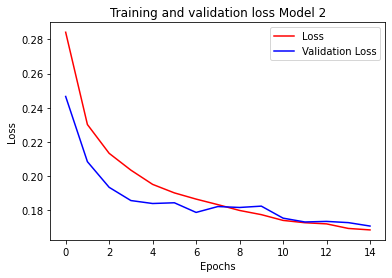

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss = history_final['loss']
val_loss = history_final['val_loss']

epochs = [*range(15)]

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss Model 2')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

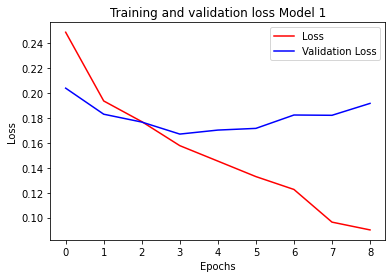

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss2 = history_model1_final['loss']
val_loss2 = history_model1_final['val_loss']

epochs2 = [*range(9)]

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs2, loss2, 'r')
plt.plot(epochs2, val_loss2, 'b')
plt.title('Training and validation loss Model 1')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

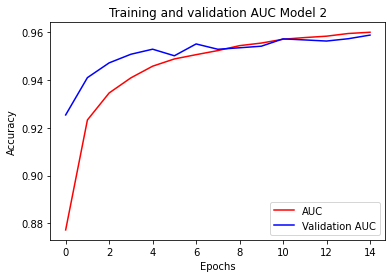

In [ ]:
auc = history_final['auc']
val_auc = history_final['val_auc']

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, auc, 'r')
plt.plot(epochs, val_auc, 'b')
plt.title('Training and validation AUC Model 2')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["AUC", "Validation AUC"])
plt.show()

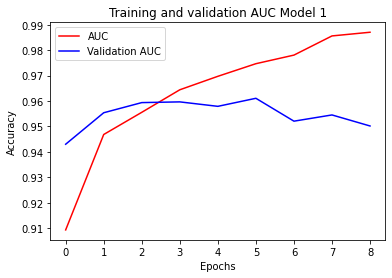

In [ ]:
auc2 = history_model1_final['auc_1']
val_auc2 = history_model1_final['val_auc_1']

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs2, auc, 'r')
plt.plot(epochs2, val_auc, 'b')
plt.title('Training and validation AUC Model 1')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["AUC", "Validation AUC"])
plt.show()

In [ ]:
# Test the slope of your val_loss curve
from scipy.stats import linregress
slope, *_ = linregress(epochs, val_loss)
print(f"The slope of your validation loss curve for model 1 is {slope:.5f}")

The slope of your validation loss curve for model 1 is -0.00329


In [ ]:
# Test the slope of your val_loss curve
from scipy.stats import linregress
slope, *_ = linregress(epochs2, val_loss2)
print(f"The slope of your validation loss curve for model 2 is {slope:.5f}")

The slope of your validation loss curve for model 2 is -0.00059


In [ ]:
# Test

In [ ]:
import re
import nltk
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('stopwords',  quiet=True)
nltk.download('omw-1.4', quiet=True)

stop_words = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(pos_tag):
  if pos_tag.startswith('J'):
    return 'a'
  elif pos_tag.startswith('V'):
    return 'v'
  elif pos_tag.startswith('R'):
    return 'r' # adverb
  else:
    return 'n'


def process(text):
  # lowercase
  text = text.lower()
  # remove all html tags 
  text = re.sub(r'<.*?>', '', text)
  # remove hyperlinks
  text = re.sub(r'http\S+', '', text)
  # remove special characters and punctuation
  text = re.sub('[^a-z ]', '', text)
  # split and remove stopwords
  words = [word for word in text.split() if word == 'not' or not word in stop_words]
  words_pos = pos_tag(words)
  lemmatized_words = []
  for word, tag in words_pos:
    pos = get_wordnet_pos(tag)
    lemmatized_word = lemmatizer.lemmatize(word, pos=pos)
    lemmatized_words.append(lemmatized_word)
  text = ' '.join(lemmatized_words)
  return text

In [ ]:
import argparse
import json
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model

# def parse_argument():
#     parser = argparse.ArgumentParser(description='Test')
#     parser.add_argument('--review', help='Review of the product')
#     return parser.parse_args()


def load_tokenizer():
    with open('tokenizer.json') as f:
        data = json.load(f)
        tokenizer = tokenizer_from_json(data)
    return tokenizer

def predict(review):

    tokenizer = load_tokenizer()
    
    processed_review = process(review)
    encoded_review = tokenizer.texts_to_sequences([processed_review])[0]
    encoded_review = pad_sequences([encoded_review], maxlen=MAXLEN, padding=PADD_TYPE, truncating=TRUNC_TYPE)
    # model = load_model('sentimentmodel_1.h5')
    pred = model2.predict([encoded_review])
    
    print(pred[0])

    if pred[0][0] > 0.6:
        print('Positive with {}%'.format(pred[0][0]*100))
    else:
        print('Negative with {}%'.format(100-pred[0][0]*100))

In [ ]:
Dpredict("I won't come back again")

[0.76296544]
Positive with 76.2965440750122%


In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 225, 100)          10403100  
                                                                 
 dropout (Dropout)           (None, 225, 100)          0         
                                                                 
 conv1d (Conv1D)             (None, 223, 128)          38528     
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           24640     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 55, 64)           0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 55, 512)          657408    
 l)                                                     

In [ ]:
def predict1(review):

    tokenizer = load_tokenizer()
    
    processed_review = process(review)
    encoded_review = tokenizer.texts_to_sequences([processed_review])[0]
    encoded_review = pad_sequences([encoded_review], maxlen=MAXLEN, padding=PADD_TYPE, truncating=TRUNC_TYPE)
    # model = load_model('sentimentmodel_1.h5')
    pred = model.predict([encoded_review])
    
    print(pred)

    if pred[0][0] > 0.6:
        print('Positive with {}%'.format(pred[0][0]*100))
    else:
        print('Negative with {}%'.format(100-pred[0][0]*100))

In [ ]:
predict1("I won't come back again")

[[0.32443815]]
Negative with 67.55618453025818%


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 225, 100)          10403100  
                                                                 
 bidirectional_1 (Bidirectio  (None, 225, 128)         84480     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                